# Part 1). SQL Technical Assessment: SF Bikeshare Data
I use the BigQuery API to get the san_francisco_bikeshare dataset from Google’s public BigQuery database. Then I run query based on the given questions and look for data quality, pipeline design, modeling, and business insight from each one. After that, I create an ER diagram to understand and show the relationships between the tables.

<p align="center">
  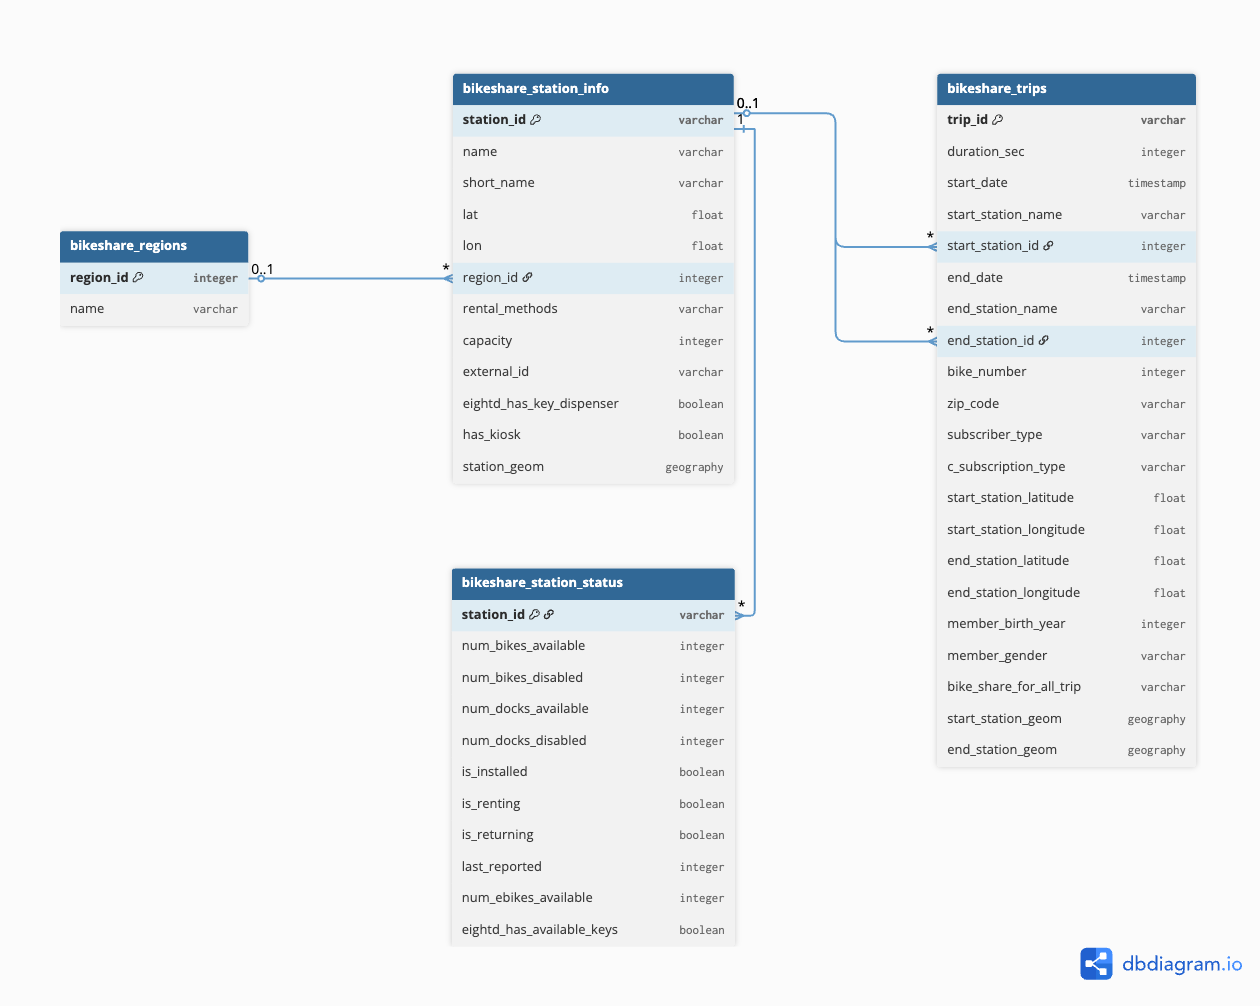
</p>
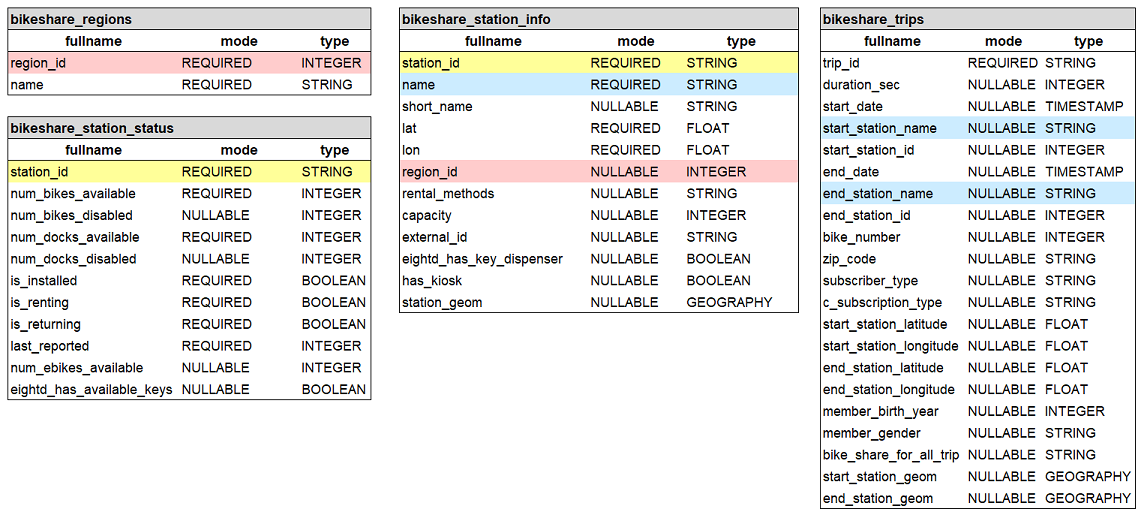

# Setup Project

In [15]:
import pandas as pd 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from google.cloud import bigquery 

# create a client object
client = bigquery.Client()

# fetch the dataset (API request) in bigquery To access the dataset 
dataset_ref = client.dataset("san_francisco_bikeshare", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

# set pandas to show all columns
pd.set_option('display.max_columns', None)

Using Kaggle's public dataset BigQuery integration.
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [16]:
tables = list(client.list_tables(dataset))

for table in tables:  
    print(table.table_id)

bikeshare_regions
bikeshare_station_info
bikeshare_station_status
bikeshare_trips


# Assessment

## 1. Write a query to identify the top 5 most frequently used starting stations. 

#### DE Insight: 
- Trips concentrate in only a few stations, which shows high data skew. So, window functions in the pipeline must handle this, for example by partition by start_date and cluster by start_station_id
- It is better to create an aggregate table such as fact_station_trip_daily instead of calculate from raw data every time

#### Data Quality:
- start_station_id and start_station_name must not be NULL
- The mapping between start_station_id and start_station_name should be 1:1 relationship
  
#### Busineess Insight:
The top 5 start stations are mostly in central San Francisco
for example
- Caltrain (rank 1 and 2): people use bikes to go from the train to other places
- Harry Bridges Plaza: near tourist spots, so many users are tourists
- Embarcadero / 2nd at Townsend: office area, so users mostly ride bikes to work

So, we should focus on build stations near train stations or public transport areas.

In [14]:
query1 = """
SELECT 
    start_station_id, 
    start_station_name, 
    COUNT(*) as use_count
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY start_station_id, start_station_name
HAVING COUNT(*) >= 1
ORDER BY use_count DESC
LIMIT 5;
         """

query_job1 = client.query(query1)
query_result1 = query_job1.to_dataframe()
query_result1

,start_station_id,start_station_name,use_count
0,70,San Francisco Caltrain (Townsend at 4th),72683
1,69,San Francisco Caltrain 2 (330 Townsend),56100
2,50,Harry Bridges Plaza (Ferry Building),49062
3,60,Embarcadero at Sansome,41137
4,61,2nd at Townsend,39936


## 2. Calculate the total number of trips that originated from stations specifically located in the "Oakland" region.
#### DE Insight: 
This query needs to join 3 tables, so it is better to create
- fact_trips
- dim_station
- dim_region

to reduce repeated joins.

#### Data Quality:
- region_id must have referential integrity
- Every station must map to a region
- Trips that cannot join to a region must be 0

In [5]:
query2 = """
SELECT 
    region.name,
    COUNT(*) as total_trip
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` AS trip
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` AS info 
    ON CAST(trip.start_station_id AS STRING) = info.station_id
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_regions` AS region 
    ON info.region_id = region.region_id
WHERE region.name = "Oakland"
GROUP BY region.name;

"""

query_job2 = client.query(query2)
query_result2 = query_job2.to_dataframe()
query_result2

,name,total_trip
0,Oakland,144522


## 3. Analysis date manipulation and basic descriptive statistics.
### Part A: For all trips occurring in the year 2015 or later, find the minimum, maximum, and average trip duration in seconds.
#### DE Insight: 
max_second is very high, so it is likely an outlier.

#### Data Quality:
1. Set a threshold check
   - duration_sec > 0
   - duration_sec < reasonable threshold (for example, less than 24 hours)
	
3. In the Gold layer, filter out outliers before use

#### Busineess Insight:
- The minimum duration is 1 minute. This may happen because users cancel the trip before they start riding, or there is a bike problem.
- The maximum duration is 24 days. This may happen because users ride for a long time, such as during a trip, or they forget to end the trip.
- The average duration is about 16 minutes, which fits short distance travel.

In [8]:
query3_1 = """
SELECT 
    MIN(duration_sec) as min_second,
    MAX(duration_sec) as max_second,
    AVG(duration_sec) as avg_second
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` as trip
WHERE EXTRACT(YEAR FROM start_date) >= 2015 
    AND duration_sec IS NOT NULL;

"""

query_job3_1 = client.query(query3_1)
query_result3_1 = query_job3_1.to_dataframe()
query_result3_1

,min_second,max_second,avg_second
0,60,2137000,960.837669


### Part B: Identify which specific year (from 2015 onwards) recorded the highest volume of trips.

#### DE Insight: 
EXTRACT(YEAR FROM start_date) AS year is used many times, so it is better to create a variable in Airflow.
#### Data Quality:
- There must be no trips with start_date as NULL
- There must be no dates later than 2018, because the current data only goes until 2018

#### Busineess Insight:
The year with the highest number of trips from 2015 onward is 2017 (data range is 2015–2018), with a total of 519,700 trips.

In [9]:
query3_2 = """
SELECT 
    EXTRACT(YEAR FROM start_date) AS year,
    COUNT(*) AS total_trip
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` AS trip
WHERE EXTRACT(YEAR FROM start_date) >= 2015
GROUP BY year
ORDER BY total_trip DESC
LIMIT 1

"""

query_job3_2 = client.query(query3_2)
query_result3_2 = query_job3_2.to_dataframe()
query_result3_2

,year,total_trip
0,2017,519700


## 4. For the year 2015, identify the very first trip taken at every single start station.

#### DE Insight: 
Use the QUALIFY clause instead of a normal window function subquery to make the code cleaner.

#### Data Quality:
This dataset has many NULL values, especially in location and demography fields, so data preparation is needed before use, for example

- Check for NULL values
- Filter latitude and longitude by join with the station info table
- Set rules if latitude or longitude is NULL, do not use the record for spatial analysis

#### Busineess Insight:
For each station, the first trip in 2015 mostly comes from Subscriber users.

In [10]:
query4 = """

SELECT *
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` AS trip
WHERE EXTRACT(YEAR FROM start_date) = 2015
QUALIFY ROW_NUMBER() OVER (PARTITION BY start_station_id 
                           ORDER BY start_date) = 1
ORDER BY start_station_id

"""

query_job4 = client.query(query4)
query_result4 = query_job4.to_dataframe()
query_result4

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,c_subscription_type,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,member_birth_year,member_gender,bike_share_for_all_trip,start_station_geom,end_station_geom
0,589014,311,2015-01-01 13:28:00+00:00,San Jose Diridon Caltrain Station,2,2015-01-01 13:33:00+00:00,Paseo de San Antonio,7,155,95126,nan,Subscriber,NaN,NaN,NaN,NaN,NaN,None,None,None,None
1,589066,17971,2015-01-01 15:26:00+00:00,San Jose Civic Center,3,2015-01-01 20:26:00+00:00,San Jose Civic Center,3,105,93308,nan,Customer,NaN,NaN,NaN,NaN,NaN,None,None,None,None
2,589822,292,2015-01-03 11:04:00+00:00,Santa Clara at Almaden,4,2015-01-03 11:09:00+00:00,San Jose Diridon Caltrain Station,2,84,95113,nan,Subscriber,NaN,NaN,NaN,NaN,NaN,None,None,None,None
3,591231,189,2015-01-05 14:59:00+00:00,Adobe on Almaden,5,2015-01-05 15:03:00+00:00,San Jose Diridon Caltrain Station,2,36,94002,nan,Subscriber,NaN,NaN,NaN,NaN,NaN,None,None,None,None
4,589044,303,2015-01-01 14:50:00+00:00,San Pedro Square,6,2015-01-01 14:55:00+00:00,St James Park,13,184,95110,nan,Subscriber,NaN,NaN,NaN,NaN,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,588930,441,2015-01-01 03:40:00+00:00,Market at Sansome,77,2015-01-01 03:47:00+00:00,Embarcadero at Bryant,54,490,94105,nan,Subscriber,NaN,NaN,NaN,NaN,NaN,None,None,None,None
66,589913,637,2015-01-03 13:20:00+00:00,Santa Clara County Civic Center,80,2015-01-03 13:31:00+00:00,Ryland Park,84,77,95112,nan,Subscriber,NaN,NaN,NaN,NaN,NaN,None,None,None,None
67,588966,1870,2015-01-01 11:56:00+00:00,Broadway St at Battery St,82,2015-01-01 12:27:00+00:00,Broadway St at Battery St,82,109,90230,nan,Customer,NaN,NaN,NaN,NaN,NaN,None,None,None,None
68,589274,276,2015-01-02 09:05:00+00:00,Mezes Park,83,2015-01-02 09:10:00+00:00,Redwood City Caltrain Station,22,61,94063,nan,Subscriber,NaN,NaN,NaN,NaN,NaN,None,None,None,None


## 5. Analyzing 2015 ridership to identify "long tail" stations. After ranking all stations from busiest to least busy, you need to isolate those that contribute to the network's volume only after the cumulative trip count has already exceeded 320,000.

#### DE Insight: 

The cumulative window should run on a mart table, such as total trips per year for each station.

#### Data Quality:
Long tail stations can be used as a baseline for anomaly detection.

#### Busineess Insight: 
The stations in the last 3 ranks are mostly hospitals.

In [11]:
query5 = """

WITH station_trip AS (
    SELECT
        start_station_id,
        start_station_name,
        COUNT(*) AS total_trip
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE EXTRACT(YEAR FROM start_date) = 2015
    GROUP BY start_station_id, start_station_name
),

cumulative_trips AS (
    SELECT 
        start_station_id,
        start_station_name,
        total_trip,
        SUM(total_trip) OVER (
            ORDER BY total_trip DESC
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
            AS cumulative_trip
    FROM station_trip
)

SELECT *
FROM cumulative_trips
WHERE cumulative_trip > 320000
ORDER BY total_trip DESC;

"""

query_job5 = client.query(query5)
query_result5 = query_job5.to_dataframe()
query_result5

,start_station_id,start_station_name,total_trip,cumulative_trip
0,46,Washington at Kearny,2657,321194
1,58,San Francisco City Hall,2080,323274
2,4,Santa Clara at Almaden,1865,325139
3,27,Mountain View City Hall,1542,326681
4,6,San Pedro Square,1315,327996
5,32,Castro Street and El Camino Real,1173,329169
6,34,Palo Alto Caltrain Station,1140,330309
7,22,Redwood City Caltrain Station,1072,331381
8,11,MLK Library,1052,332433
9,31,San Antonio Shopping Center,938,333371
